In [70]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [71]:
if torch.cuda.is_available():
  DEVICE = torch.devidce('cuda')
else:
  DEVICE = torch.device('cpu')

In [72]:
BATCH_SIZE = 32
EPOCHS = 10

In [73]:
train_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = True, 
                               download = True, 
                               transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = False,
                               transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = BATCH_SIZE,
                                         shuffle = False)

In [74]:
for (X_train, y_train) in train_loader :
    print('X_train:',X_train.size(),'type:', X_train.type()) #class=1 흑백
    print('y_train:',y_train.size(),'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


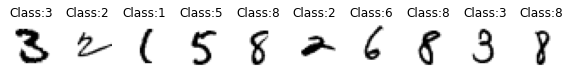

In [75]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :,:,:].numpy().reshape(28,28),cmap='gray_r')
    plt.title('Class:'+ str(y_train[i].item()))

In [76]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512) #FC Layer 1
        self.fc2 = nn.Linear(512,256)    #FC Layer 2
        self.fc3 = nn.Linear(256, 10)    #FC Layer 3
    def forward(self, x):
        x = x.view(-1, 28*28)            #flatten 2차원의 이미지데이터를 1차원으로
        x = self.fc1(x)                  #첫번째 층 통과
        x = F.sigmoid(x)                 #활성화함수
        x = self.fc2(x)                     #두번째 층 통과
        x = F.sigmoid(x)                 #활성화함수
        x = self.fc3(x)                     #세번째 층 통과
        x = F.log_softmax(x, dim=1)       #분류 whylog? backpropagation 쉽게하기위해서
        return x

In [77]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss() #output과 원-핫 인코딩 값과의 loss를 crossentropy로 계산하기 위함.

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [78]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward() #gradients 저장
        optimizer.step() #update
        
        if batch_idx % log_interval == 0 :
            print("Train Epoch: {} [{}/{}({:.0f}%)]|tTrain Loss: {:.6f}".format(Epoch, batch_idx*len(image),
                 len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

In [79]:
def evaluate(model, test_loader):
    model.eval() #평가상태
    test_loss = 0 
    correct = 0 
    
    with torch.no_grad(): #평가하는 단계에서 gradients 학습방지(흐름억제)
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]  #크기 10인 벡터 그 안에서 가장 큰 확률값을 고름
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)  #minibatch개수만큼 나눠서 평균 loss 값으로 계산
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy         

In [80]:
for Epoch in range(1, EPOCHS + 1 ):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("/n[Epoch:{}], |tTest Loss:{:.4f}, |tTest Accuracy: {:.2f} %|n".format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000(0%)]|tTrain Loss: 2.345613
Train Epoch: 1 [6400/60000(11%)]|tTrain Loss: 2.325133
Train Epoch: 1 [12800/60000(21%)]|tTrain Loss: 2.267796
Train Epoch: 1 [19200/60000(32%)]|tTrain Loss: 2.287272
Train Epoch: 1 [25600/60000(43%)]|tTrain Loss: 2.244538
Train Epoch: 1 [32000/60000(53%)]|tTrain Loss: 2.278691
Train Epoch: 1 [38400/60000(64%)]|tTrain Loss: 2.287987
Train Epoch: 1 [44800/60000(75%)]|tTrain Loss: 2.248889
Train Epoch: 1 [51200/60000(85%)]|tTrain Loss: 2.289541
Train Epoch: 1 [57600/60000(96%)]|tTrain Loss: 2.183481
/n[Epoch:1], |tTest Loss:0.0696, |tTest Accuracy: 33.22 %|n
Train Epoch: 2 [0/60000(0%)]|tTrain Loss: 2.235180
Train Epoch: 2 [6400/60000(11%)]|tTrain Loss: 2.196136
Train Epoch: 2 [12800/60000(21%)]|tTrain Loss: 2.163996
Train Epoch: 2 [19200/60000(32%)]|tTrain Loss: 2.129355
Train Epoch: 2 [25600/60000(43%)]|tTrain Loss: 1.940958
Train Epoch: 2 [32000/60000(53%)]|tTrain Loss: 1.812131
Train Epoch: 2 [38400/60000(64%)]|tTrain Loss: 1.702019
